In [121]:
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
from konlpy.tag import Okt
from collections import Counter

In [3]:
nsmc_train_df = pd.read_csv('data/ratings_train.txt', encoding = 'utf8', sep = '\t',
engine = 'python')
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [6]:
nsmc_train_df =nsmc_train_df[nsmc_train_df['document'].notnull()]


In [7]:
nsmc_train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [8]:
nsmc_train_df['label'].value_counts()


0    75170
1    74825
Name: label, dtype: int64

In [9]:
import re

In [11]:
nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [12]:
nsmc_test_df = pd.read_csv('data/ratings_test.txt', encoding = 'utf8', sep = '\t',engine = 'python')
nsmc_test_df.head()


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [13]:
nsmc_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [14]:
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()] 

In [15]:
nsmc_test_df['label'].value_counts()

1    25171
0    24826
Name: label, dtype: int64

In [16]:
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

In [17]:
from konlpy.tag import Okt
okt = Okt()

In [18]:
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range = (1, 2), min_df = 3, max_df = 0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])

In [21]:
from sklearn.linear_model import LogisticRegression
SA_lr = LogisticRegression(random_state = 0)

In [22]:
 SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])


LogisticRegression(random_state=0)

In [23]:
from sklearn.model_selection import GridSearchCV
params = {'C': [1, 3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)

In [24]:
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [25]:
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

{'C': 3} 0.8553


In [26]:
#최적 매개변수의 best 모델 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

In [27]:
#평가용 데이터의 피처 벡터화
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

In [28]:
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

In [29]:
from sklearn.metrics import accuracy_score
print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.858


In [55]:
st = input('감성 분석할 문장 입력 >> ')


감성 분석할 문장 입력 >>  어쩔티비 저쩔티비 삼성티비


In [56]:
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st) ; print(st)
st = [" ".join(st)] ; print(st)

['어쩔티비', '저쩔티비', '삼성티비']
['어쩔티비 저쩔티비 삼성티비']


In [57]:
#1) 입력 텍스트의 피처 벡터화
st_tfidf = tfidf.transform(st)
#2) 최적 감성 분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)


In [58]:
#3) 예측값 출력하기
if(st_predict == 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

['어쩔티비 저쩔티비 삼성티비'] ->> 부정 감성


In [60]:
import json
file_name = '코로나_naver_news'
with open('data/'+ file_name+'.json', encoding = 'utf8') as j_f:data= json.load(j_f)

In [62]:
data_title = []
data_description = []
for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])


In [64]:
import pandas as pd
data_df = pd.DataFrame({'title':data_title, 'description':data_description})

In [65]:
data_df['title']=data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description']=data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df.head()

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...


In [67]:
#1) 분석할 데이터의 피처 벡터화 ---<< title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])
# #2) 최적 매개변수 학습 모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)
# #3) 감성 분석 결과값을 데이터프레임에 저장
data_df['title_label'] = data_title_predict

In [68]:
#1) 분석할 데이터의 피처 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])
#2) 최적 매개변수 학습 모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)
#3) 감성 분석 결과값을 데이터프레임에 저장
data_df['description_label'] = data_description_predict

In [69]:
data_df.to_csv('data/'+file_name+'.csv', encoding = 'UTF-8')

In [70]:
data_df.head()

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0,0
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...,0,1
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...,0,0


In [74]:
print(data_df['title_label'].value_counts())


0    485
1    315
Name: title_label, dtype: int64


In [73]:
print(data_df['description_label'].value_counts())

0    430
1    370
Name: description_label, dtype: int64


In [75]:
columns_name = ['title', 'title_label', 'description', 'description_label']
NEG_data_df = pd.DataFrame(columns = columns_name)
POS_data_df = pd.DataFrame(columns = columns_name)
for i, data in data_df.iterrows():
    title = data["title"]
    description = data["description"]
    t_label = data["title_label"]
    d_label = data["description_label"]
    if d_label == 0: #부정 감성 샘플만 추출
        NEG_data_df = NEG_data_df.append(pd.DataFrame([[title, t_label, description,
        d_label]],columns = columns_name), ignore_index = True)
    else : #긍정 감성 샘플만 추출
        POS_data_df = POS_data_df.append(pd.DataFrame([[title, t_label, description, d_label]], columns
        = columns_name), ignore_index = True)
#파일에 저장
NEG_data_df.to_csv('data/'+file_name+'_NES.csv', encoding = 'UTF-8')
POS_data_df.to_csv('data/'+file_name+'_POS.csv', encoding = 'UTF-8')


In [76]:
len(NEG_data_df), len(POS_data_df)

(430, 370)

In [77]:
POS_description = POS_data_df['description']


In [78]:
POS_description_noun_tk = []
for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d))

In [79]:
print(POS_description_noun_tk) 

[['변화', '핵심', '중', '우리', '사회', '신종', '코로나', '바이러스', '감염증', '코로나', '의', '위기', '마주', '언제', '끝', '날', '또', '앞', '미래', '국가', '국민', '어려움', '해결', '저희'], ['한편', '코로나', '로', '해외', '식', '재료', '사재기', '국민', '먹거리', '안정', '생산', '것', '포스트', '코로나', '의', '과제', '부각', '농민', '기본소득', '도입', '통해', '안정', '생산', '기반', '확충', '것'], ['최근', '갤러리', '현대', '창업', '주년', '기념', '전', '이', '작품', '전시', '코로나', '의', '영향', '마스크', '착용', '관람객', '미술', '트렌드', '한국', '미술', '시장', '글', '정태희', '서울', '옥션', '스페셜리스트', '세계', '경기', '침체', '코로나', '여파'], ['코로나', '감안', '차', '면접', '비대', '역량', '검사', '도입', '국내', '최대', '치킨', '프랜차이즈', '제너시스', '비비큐', '회장', '채용', '관계자', '한국', '대표', '책임감', '브랜드', '로서', '코로나', '로', '침체', '채용', '분위기'], ['일', '오후', '서울', '중랑구', '의료', '의료', '잠시', '콘서트', '신종', '코로나', '바이러스', '감염증', '코로나', '환자', '진료', '위해', '수고', '온', '의료', '진', '가수', '폴', '킴', '공연', '보고', '뉴스'], ['플립', '러닝', '온라인', '학습', '후', '교실', '토론', '및', '심화', '학습', '거꾸로', '교실', '불리', '포스트', '코로나', '시대', '교육', '방식', '주목', '아르고', '리더십', '편', '상황', '게임', '통해', '리더십', '유형

In [80]:
POS_description_noun_join = []
for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1보다 큰 토큰만 추출
    POS_description_noun_join.append(" ".join(d2)) #토큰 연결하여 리스트 구성

In [81]:
print(POS_description_noun_join) #작업 확인용 출력

['변화 핵심 우리 사회 신종 코로나 바이러스 감염증 코로나 위기 마주 언제 미래 국가 국민 어려움 해결 저희', '한편 코로나 해외 재료 사재기 국민 먹거리 안정 생산 포스트 코로나 과제 부각 농민 기본소득 도입 통해 안정 생산 기반 확충', '최근 갤러리 현대 창업 주년 기념 작품 전시 코로나 영향 마스크 착용 관람객 미술 트렌드 한국 미술 시장 정태희 서울 옥션 스페셜리스트 세계 경기 침체 코로나 여파', '코로나 감안 면접 비대 역량 검사 도입 국내 최대 치킨 프랜차이즈 제너시스 비비큐 회장 채용 관계자 한국 대표 책임감 브랜드 로서 코로나 침체 채용 분위기', '오후 서울 중랑구 의료 의료 잠시 콘서트 신종 코로나 바이러스 감염증 코로나 환자 진료 위해 수고 의료 가수 공연 보고 뉴스', '플립 러닝 온라인 학습 교실 토론 심화 학습 거꾸로 교실 불리 포스트 코로나 시대 교육 방식 주목 아르고 리더십 상황 게임 통해 리더십 유형', '도배 장판 침대 장롱 가구 교체 코로나 예방 방역 진행 주거 환경 조성 미자 양동 동장 이웃 위해 봉사', '코로나 사태 가운데 병영 생활 손흥민 경험 영국 화제 손흥민 서로 금방 이서 정말 서로 호흡', '청와대 해외 보가 문재인 대통령 포스트 코로나 시대 경제위기 정상회담 통해 양국 협력 에너지 의료 확장 최근 카타르 코로나 관련', '맥도날드 코로나 방역 작업 대구 지하철 청소 근로자 빅맥 커피 증정 패션 업계 나눔 활동 동참 코오롱 인더스 트리 직원 성과 상금 만원 코로나 어려움', '정하영 김포시 혁신 교육 지구 사업 특수교육 대상자 사업 별도 편성 소외 학생 면서 코로나 교육과정 운영 판단 학생 안전 방역', '군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포로 번길 거주 자료 군포 시청 군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포 시청 공식 블로그 통해 서울시', '명품 함양 양파 특판전 모습 사진 제공 함양군 함양군 롯데 마트 서울 역점 양파 소비 촉진 판촉 행사 코로나 농심 위로 함양군

In [83]:
NEG_description = NEG_data_df['description']
NEG_description_noun_tk = []
NEG_description_noun_join = []
for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #명사 형태소만 추출
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1보다 큰 토큰만 추출
    NEG_description_noun_join.append(" ".join(d2)) # 토큰 연결하여 리스트 구성

In [84]:
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

In [85]:
POS_vocab = dict()
for idx, word in enumerate(POS_tfidf.get_feature_names()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()
    POS_words = sorted(POS_vocab.items(), key = lambda x: x[1], reverse = True)

In [86]:
POS_words

[('코로나', 29.58865817494428),
 ('의료', 13.461836434575911),
 ('위해', 11.469142512665115),
 ('바이러스', 9.626197092990505),
 ('신종', 9.241355937335499),
 ('감염증', 8.876275469712054),
 ('온라인', 7.6638009611810896),
 ('시대', 7.638747100423279),
 ('확산', 7.462304300911354),
 ('사회', 7.331187766652533),
 ('이번', 6.953637262299177),
 ('지역', 6.7931464306235565),
 ('어려움', 6.57884559465247),
 ('통해', 6.500569971401247),
 ('극복', 6.067323212381158),
 ('포스트', 6.02648184365831),
 ('기업', 5.899827006908783),
 ('서울', 5.432782197187217),
 ('사태', 5.340689961243574),
 ('방역', 5.308659591090857),
 ('최근', 5.285143543921558),
 ('언택트', 5.185701361355053),
 ('상황', 5.129043847943381),
 ('환자', 5.111079129368619),
 ('정부', 5.069719087512996),
 ('사업', 5.045688264465154),
 ('경제', 5.043712031592348),
 ('생활', 5.034230080207947),
 ('대표', 5.031840422108942),
 ('올해', 5.011379038211078),
 ('공연', 4.936538589036854),
 ('우리', 4.898794126455551),
 ('비대', 4.802827030463792),
 ('한국', 4.770201020213962),
 ('개발', 4.767977722488553),
 ('진자', 4.

In [87]:
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

In [88]:
NEG_vocab = dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
    NEG_words = sorted( NEG_vocab.items(), key = lambda x: x[1], reverse = True)

In [90]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname =
font_location).get_name()
matplotlib.rc('font', family = font_name)
max = 15

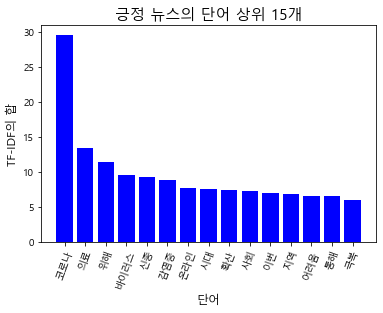

In [91]:
plt.bar(range(max), [i[1] for i in POS_words[:max]], color = "blue")
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation = 70)
plt.show()


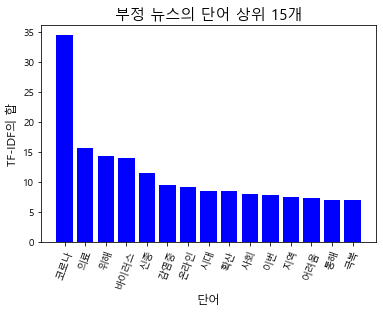

In [93]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color = "blue")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize = 15)
plt.xlabel("단어", fontsize = 12)
plt.ylabel("TF-IDF의 합", fontsize = 12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation = 70)
plt.show()

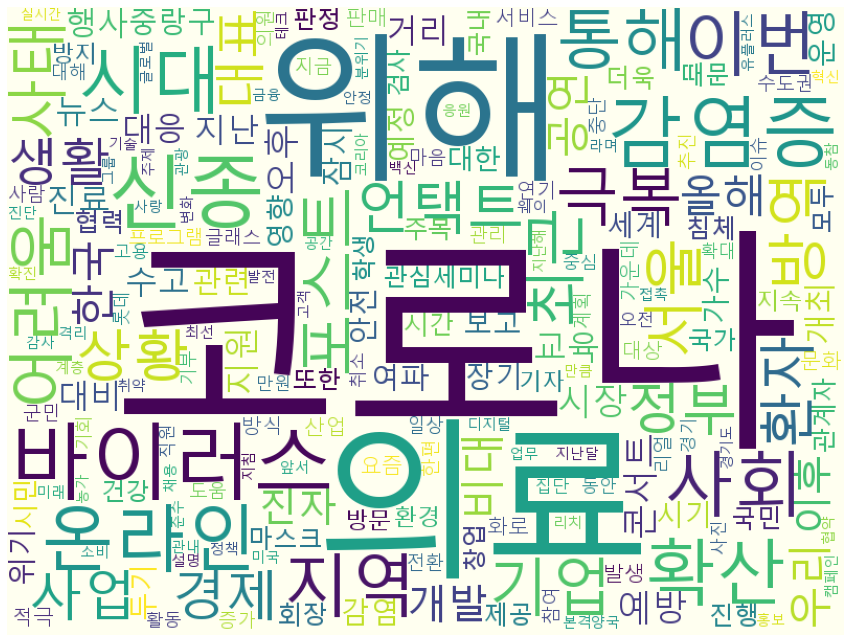

In [133]:
wc =WordCloud(font_path, background_color ='ivory', width =800, height =600)

cloud = wc.generate_from_frequencies(POS_vocab)
f = plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

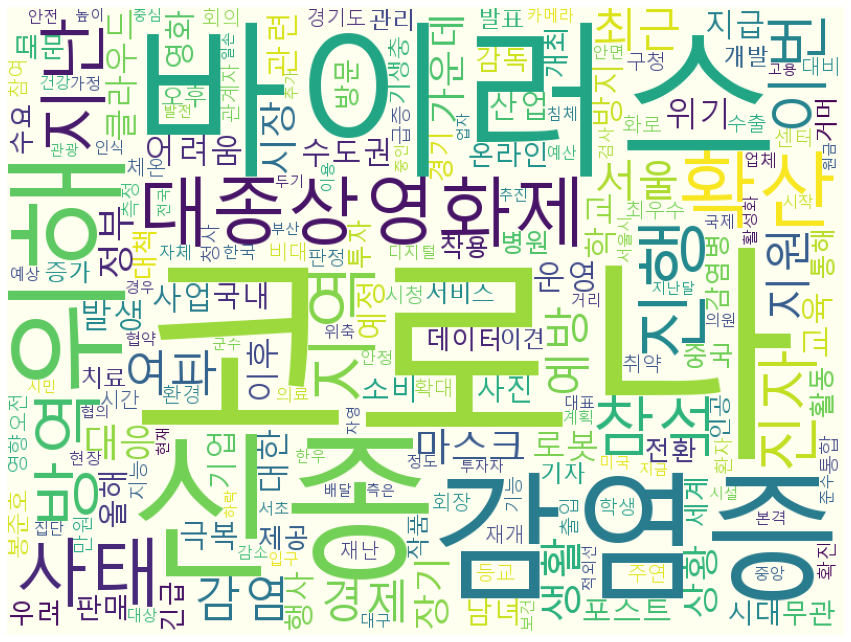

In [134]:
wc =WordCloud(font_path, background_color ='ivory', width =800, height =600)

cloud = wc.generate_from_frequencies(NEG_vocab)
f = plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()